In [1]:
from tqdm import tqdm
from D3QNAgent import Agent
from kaggle_environments import evaluate, make, utils
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

env = make("connectx", debug=True)
env.render()

nstep_lookahead_agent = './fast_Nstep_lookahead_agent.py'
random_agent = 'random'
negamax_agent = 'negamax'

Loading environment football failed: No module named 'gfootball'


In [2]:
from D3QNAgent import Agent
def random_agent_refined(obs, config):
    agent = Agent(config)
    agent.load_model('./2000_episodes_random')
    return agent.choose_action(obs.board)

In [3]:
def live_plot(rewards, winloss):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=120, figsize=(12.8, 3.6))
    ax1.plot(np.array(rewards), color='orange', linestyle='-')
    ax1.legend(loc='lower right')
    ax1.set_ylabel('reward')
    ax1.set_xlabel('episode')
    ax1.title.set_text('Agent Total Rewards with Moving Average 100 Episodes')
    

    ax2.plot(np.array(winloss), color='royalblue', linestyle='-')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Expectation')
    ax2.set_xlabel('episode')
    ax2.title.set_text('Win/Loss/Draw Expectation with Moving Average 100 Episodes')
    plt.show()

    # print('episode', i, 
    #     # '\ttotal rewards %.1f' % tot_reward, 
    #     '\taverage rewards %.3f' % avg_rewards[i], 
    #     # '\tresult ', reward, 
    #     '\twin/loss ratio %.3f' % wl_ratio[i], 
    #     '\tepsilon %.3f' % agent.epsilon)

In [4]:
agent = Agent(env.configuration, 
              lr=1e-4, 
              gamma=0.95, 
              batch_size=64,    #### REMEMBER TO CHANGE IT BACK ####
              epsilon=1,        #### REMEMBER TO CHANGE IT BACK ####
              eps_dec=0.999, 
              eps_min=1e-2, 
              buff_size=100_000, 
              d1_dims=64, 
              d2_dims=64,
              d3_dims=32,
              d4_dims=32,
              replace_target_weight=15)

In [5]:
# Play as first position against nstep_lookahead agent.
trainer = env.train([None, random_agent_refined])

rewards, avg_rewards, result, eps_history, wl_ratio = [], [], [], [], []

In [6]:

num_episodes = 2000

No handles with labels found to put in legend.
No handles with labels found to put in legend.


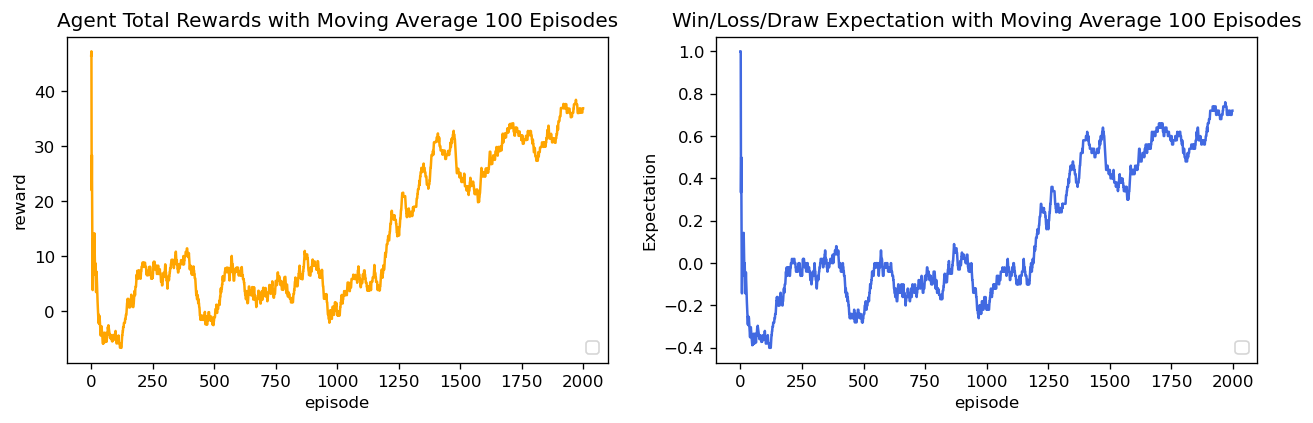

In [7]:
for i in range(num_episodes):
    done = False
    tot_reward = 0
    obs = trainer.reset().board
    
    while not done:
        # choose the best action
        action = agent.choose_action(obs)
        
        # step the environment with action
        # store all returns
        obs_, reward, done, info = trainer.step(action)

        
        # calculate agent reward from environment response
        agent_reward = agent.get_agent_reward(reward, done)
        
        tot_reward += agent_reward
        
        # store this transition
        agent.update_replay_buffer((obs, action, reward, obs_.board, done))
        
        # update the current obs with new obs
        obs = obs_.board
        
        
        agent.learn()
    
    agent.evolve()

    # store final game result
    result.append(reward)
    # store epsilon
    eps_history.append(agent.epsilon)
    # store total rewards
    rewards.append(tot_reward)
    # store average rewards
    avg_rewards.append(np.mean(rewards[-100:]))
    wl_ratio.append(np.mean(result[-100:]))
    


    if i % 100 == 0:
        live_plot(avg_rewards, wl_ratio)
        
    env.render()

live_plot(avg_rewards, wl_ratio)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(500), avg_rewards, '-')
ax.set_ylim([-30, -20])

In [8]:
agent.save_model('./2000_episodes_random_retrained')

INFO:tensorflow:Assets written to: ./2000_episodes_random_retrained\assets


In [9]:
from D3QNAgent import Agent
def my_agent(obs, config):
    agent = Agent(config)
    agent.load_model('./2000_episodes_random_retrained')
    return agent.choose_action(obs.board)

In [14]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, "random"])
env.render(mode="ipython", width=500, height=450)

In [13]:
# def mean_reward(rewards):
#     return sum(r[0] for r in rewards) / float(len(rewards))
    
# print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))